# Baseline : Clustering

In [6]:
from google.colab import files
uploaded = files.upload()

Saving neighbourhood.csv to neighbourhood.csv


In [7]:
# The objective here is to run the same models as we did in baseline 

import pandas as pd
import numpy as np
import matplotlib
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.cm as cmx
import matplotlib.colors as colors
from sklearn import linear_model
import sklearn.metrics as metrics
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression as Lin_Reg
from sklearn.linear_model import Ridge as Ridge_Reg
from sklearn.linear_model import RidgeCV
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso as Lasso_Reg
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import pylab
import scipy.stats as stats
import math
%matplotlib inline

In [8]:
# This particular set of code will create a helper function for plotting residual plots

def plot_residual(ax1, ax2, ax3, y_pred, y_real, line_label, title):
    ax1.scatter(y_pred, 
                y_real, 
                color='blue',
                alpha=0.6,
                label=line_label)
    ax1.set_xlabel('Predicted Y') 
    ax1.set_ylabel('Real Y')
    ax1.legend(loc='best')
    ax1.set_title(title)

    ax2.scatter(y_pred,
                y_real - y_pred, 
                color='green',
                marker='x',
                alpha=0.6,
                label='Residual')
    ax2.set_xlabel('Predicted Y')
    ax2.set_ylabel('Residual')
    
    ax2.axhline(y=0, color='black', linewidth=2.0, alpha=0.7, label='y=0')

    ax2.legend(loc='best')
    ax2.set_title('Residual Plot')
    
    ax3.hist(y_real - y_pred, bins=30, color='green', alpha=0.7)
    ax3.set_title('Histogram of residual values')
    
    return ax1, ax2, ax3

In [9]:
# Here I will create a Model class

class model:
    
    def __init__(self, model):
        self.model = model
        self.x_train = None
        self.y_train = None
        self.x_test = None
        self.y_test = None
        self.y_pred_train = None
        self.y_pred_test = None
        self.train_score = None
        self.test_score = None
        self.train_score_log = None
        self.test_score_log = None
    
    def data_split(self, x, y, test_size):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(x, y, test_size=test_size)
    
    def score_reg(self):
        return self.train_score, self.test_score
    
    def score_log(self):
        self.train_score_log = metrics.r2_score(np.exp(self.y_train), np.exp(self.y_pred_train))
        self.test_score_log = metrics.r2_score(np.exp(self.y_test), np.exp(self.y_pred_test))
        return self.train_score_log, self.test_score_log
    
    def data_frame_convert(self):
        df_train = pd.DataFrame({'y_pred': self.y_pred_train, 'y_real': self.y_train})
        df_test = pd.DataFrame({'y_pred_test': self.y_pred_test, 'y_real_test': self.y_test})
        return self.train_score, self.test_score, df_train, df_test

    def data_frame_convert_log(self):
        df_train = pd.DataFrame({'y_pred': np.exp(self.y_pred_train), 'y_real': np.exp(self.y_train)})
        df_test = pd.DataFrame({'y_pred_test': np.exp(self.y_pred_test), 'y_real_test': np.exp(self.y_test)})
        return self.train_score_log, self.test_score_log, df_train, df_test
    
    def fit_model(self, x, y, test_size):
        self.data_split(x, y, test_size)
        self.model = self.model.fit(self.x_train, self.y_train)
        self.train_score = self.model.score(self.x_train, self.y_train)
        self.test_score = self.model.score(self.x_test, self.y_test)
        self.y_pred_train = self.model.predict(self.x_train)
        self.y_pred_test = self.model.predict(self.x_test)
    
def model_iterations(n, x, y, model_arg, log_bool=False):
    new_model = model(model_arg)
    training_scores = [None]*n
    testing_scores = [None]*n

    for i in range(n):
        new_model.fit_model(x, y, 0.3)
        training_scores[i], testing_scores[i] = new_model.score_reg() if not log_bool else new_model.score_log()

    print('Mean Train Score:', np.mean(training_scores))
    print('Mean Test Score:', np.mean(testing_scores))
    return new_model

In [12]:
# Now I will read in the neighbourhood dataset

df = pd.read_csv('neighbourhood.csv')

In [13]:
# Here I will split the data into x and y
# In this, I do not include id and host_id

x = df.iloc[:, 2:-2]
y = df.iloc[:, -2]
y_log = df.iloc[:, -1]

In [14]:
# I will run Ridge and Lasso Regression Models using Un-Transformed and Transformed
# Response

# I will start with a RR w/ Untransformed Response
reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(1, x, y, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5))

Mean Train Score: 0.2948634112579166
Mean Test Score: 0.36530451552578924


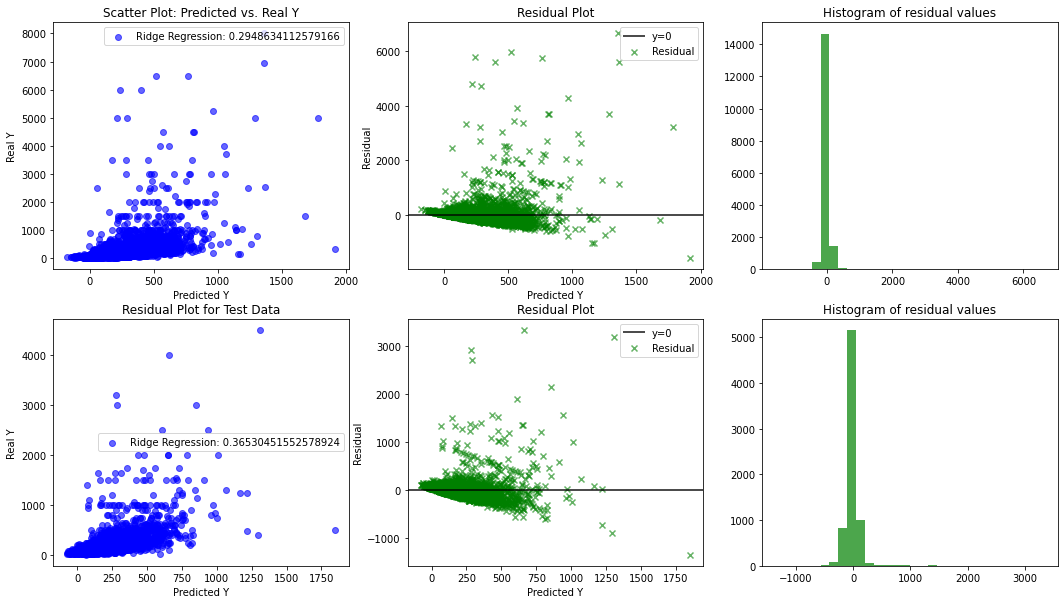

In [16]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

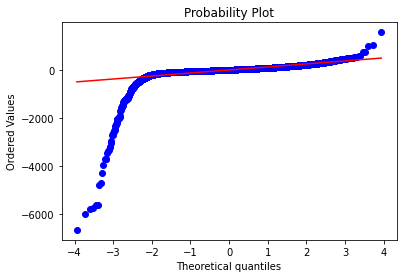

In [18]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

In [19]:
# Now I will run a RR Model with a Log-Transformed Response

reg_params = 10.**np.linspace(-10, 5, 10)
RidgeCV_model = model_iterations(5, x, y_log, RidgeCV(alphas=reg_params, fit_intercept=True, cv=5), True)

Mean Train Score: 0.33675216117267404
Mean Test Score: 0.31829989976348994


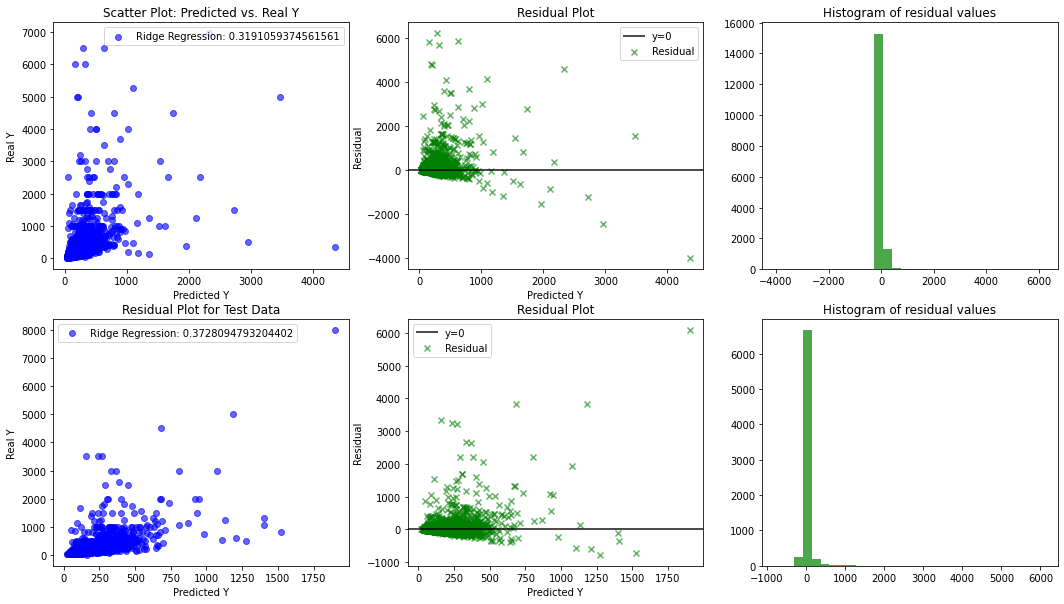

In [20]:
# plot the residuals of a ridge regression model
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

ridge_data_vals = RidgeCV_model.data_frame_convert_log()
plot_residual(axes[0][0], axes[0][1], axes[0][2], ridge_data_vals[2]['y_pred'], ridge_data_vals[2]['y_real'], 'Ridge Regression: {}'.format(ridge_data_vals[0]), 'Scatter Plot: Predicted vs. Real Y')
plot_residual(axes[1][0], axes[1][1], axes[1][2], ridge_data_vals[3]['y_pred_test'], ridge_data_vals[3]['y_real_test'], 'Ridge Regression: {}'.format(ridge_data_vals[1]), 'Residual Plot for Test Data')
plt.show()

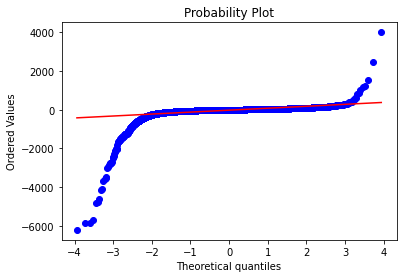

In [21]:
# qq plot for the train residuals
stats.probplot(ridge_data_vals[2]['y_pred'] - ridge_data_vals[2]['y_real'], dist="norm", plot=pylab)
pylab.show()

In [22]:
# The next couple of cells will be a Lasso Regression Model with both the Untransformed
# Response and Log-Transformed Response, starting w/ an Untransformed Response.

reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y, LassoCV(alphas=reg_params, fit_intercept=True, cv=5))

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 15879261.453493357, tolerance: 78014.38825593586
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67106951.106853366, tolerance: 78014.38825593586
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 67106758.34943956, tolerance: 78014.38825593586
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incr

Mean Train Score: 0.31593668866294766
Mean Test Score: 0.2964105938599829


In [24]:
# Log-Transformed Response

reg_params = 10.**np.linspace(-10, 5, 10)
LassoCV_model = model_iterations(5, x, y_log, LassoCV(alphas=reg_params, fit_intercept=True, cv=5), True)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 16.27146402554945, tolerance: 0.587770614166817
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.39469826080108, tolerance: 0.587770614166817
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51.38572982429423, tolerance: 0.587770614166817
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increa

Mean Train Score: 0.3302879334901941
Mean Test Score: 0.3444739849971854


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 230.1229652623433, tolerance: 0.7316429049680429
  positive)


# Conclusion:
  * When I cluster by neighbourhood, I can see that it performs along side that of the original dataset with zipcodes. 

  * We will take a look at the Median Absolute Error next.

In [25]:
# Median Absolute Error

def median_absolute_errors(x, y, log_bool=None):
    reg_params = 10.**np.linspace(-10, 5, 10)
    models = [ linear_model.Ridge(), RidgeCV(alphas=reg_params, cv=5), linear_model.Lasso(), LassoCV(alphas=reg_params, cv=5), linear_model.ElasticNet(), linear_model.BayesianRidge(), linear_model.OrthogonalMatchingPursuit() ]
    model_labels = np.array(['Ridge', 'RidgeCV', 'Lasso', 'LassoCV', 'ElasticNet', 'BayesRidge', 'OMP'])
    model_errors = np.array([])

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.35, random_state=15)

    for model in models:
        model.fit(X_train, y_train)
        if not log_bool:
            model_err = metrics.median_absolute_error((y_test), model.predict(X_test))
            model_errors = np.append(model_errors, model_err)
        else:
            model_err = metrics.median_absolute_error(np.exp(y_test), np.exp(model.predict(X_test)))
            model_errors = np.append(model_errors, model_err)
    
    model_position = np.arange(model_errors.shape[0])
    models_sorted = np.argsort(model_errors)
    for i, model in enumerate(model_labels):
        print('Model {} Results: {}'.format(model_labels[i], model_errors[i]))

    plt.figure(figsize=(10,8))
    plt.bar(model_position, model_errors[models_sorted], align='center')
    plt.xticks(model_position, model_labels[models_sorted])
    plt.xlabel('Estimator')
    plt.ylabel('Median Absolute Error')
    plt.show()

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 435911.4783627987, tolerance: 61844.699668217814
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11408361.839345992, tolerance: 61844.699668217814
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 11408215.554546118, tolerance: 61844.699668217814
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to i

Model Ridge Results: 45.07336168651898
Model RidgeCV Results: 44.04174750898936
Model Lasso Results: 41.14837741367063
Model LassoCV Results: 41.14837741367063
Model ElasticNet Results: 44.42114343452515
Model BayesRidge Results: 44.88140250166359
Model OMP Results: 44.16731818486144


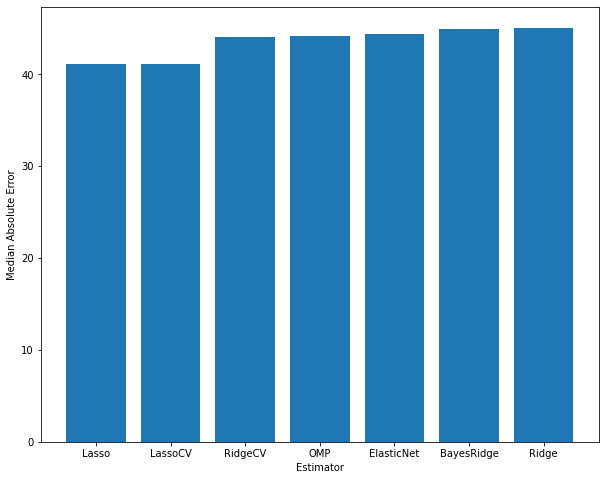

In [26]:
# Untransformed Response

median_absolute_errors(x, y)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 8.986593739315595, tolerance: 0.5529877745362821
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.37040368925, tolerance: 0.5529877745362821
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 49.36163269451072, tolerance: 0.5529877745362821
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increa

Model Ridge Results: 25.366415777488058
Model RidgeCV Results: 25.366415777488058
Model Lasso Results: 53.95756205135477
Model LassoCV Results: 25.370585935944717
Model ElasticNet Results: 53.95756205135477
Model BayesRidge Results: 25.348280885850826
Model OMP Results: 27.73053044008097


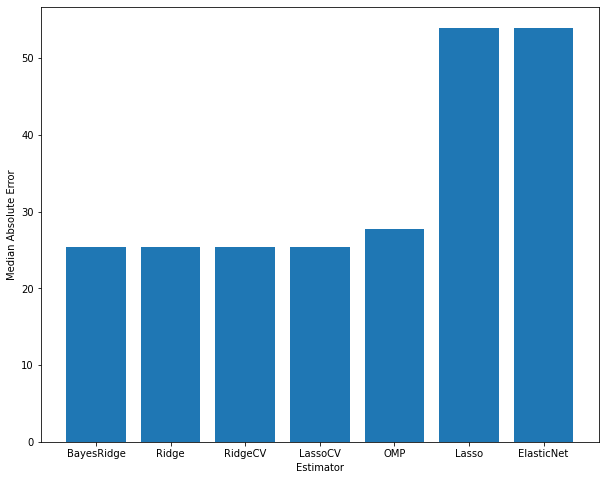

In [27]:
# Log-Transformed Response

median_absolute_errors(x, y_log, True)

## Conclusion:

  * Speculation could be made that perhaps the model benefitted from the segmenting by zipcodes rather than grouping(overlapping) them into neighbourhoods. 